## Extraction of car features from all images

### Needs to be run before test-model and cluster !!
test-model and cluster need the `all_cars.npy` file that this notebook creates

This notebook is dedicated to cropping the car out of all the images. 
And then testing a model for extracting the features. 

In [1]:
from ultralytics import YOLO
import numpy as np
import os
import polars as pl
from ultralytics import settings
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from ultralytics.utils.plotting import Annotator
import rembg

extract = YOLO("runs/detect/train6/weights/best.pt")

In [2]:
def display_image(img_array, size=640):
    img = Image.fromarray(img_array)
    img = img.resize((size, int(img.height // (img.width / size))))
    display(img)

In [15]:

def extract_cars(img, conf=0.128):
    results = extract(img, conf=conf)
    img_array = np.array(img)
    for result in results:
        for box in result.boxes:
            # Extract bounding box coordinates
            left, top, right, bottom = box.xyxy[0].int().tolist()
            # display_image(cv2.rectangle(img_array.copy(), (left, top), (right, bottom), (200, 50, 20), 40))
            # display_image(img_array[top:bottom, left:right])
            car = rembg.remove(img_array[top:bottom, left:right])[:, :, [0, 1, 2,]]
            # display_image(car)
            yield car
            
SIZE = 128
cars = []
image_paths = "all_images/"
paths = []
# fill up test_images with similar images to test.
for i, image_path in enumerate(os.listdir(image_paths)):
    print(i, image_path)
    image_path = os.path.join(image_paths, image_path)
    img = Image.open(image_path)
    img_np = np.array(img)  # Convert PIL image to NumPy array
    # display_image(img_np)
    for car in extract_cars(img, conf=0.5):
        car = cv2.resize(car, dsize=(SIZE, SIZE))
        car = car[14:SIZE-14, 14:SIZE-14]
        cars.append(car)
        paths.append(image_path)
with open("cars.txt", "w+") as f:
    f.writelines(paths)
cars = np.array(cars)

0 3937dec6-0ae8-4743-8dde-5edf2ed2c69b.png

0: 448x640 1 car, 27.4ms
Speed: 2.1ms preprocess, 27.4ms inference, 3.4ms postprocess per image at shape (1, 3, 448, 640)
1 79bf6411-2122-40e8-aea7-06929faaf8d8.png

0: 448x640 (no detections), 27.1ms
Speed: 1.8ms preprocess, 27.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)
2 0c686ed3-8b6e-4371-b1c6-41220f0194b0.png

0: 448x640 1 car, 26.9ms
Speed: 1.9ms preprocess, 26.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)
3 15bd4714-44bb-44d0-aa4d-3c481c22b0b9.png

0: 448x640 1 car, 43.5ms
Speed: 2.0ms preprocess, 43.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
4 7b801b9f-bf35-4b77-be8d-e20abf462f0d.png

0: 448x640 1 car, 42.8ms
Speed: 1.9ms preprocess, 42.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)
5 68eac2e9-a456-42c0-be26-074791623319.png

0: 448x640 1 car, 27.1ms
Speed: 1.9ms preprocess, 27.1ms inference, 0.6ms postprocess per image at shape (1, 3, 448,

In [4]:
## save extracted cars for later.

with open("cars_all.npy", "wb+") as f:
    np.save(f, cars)

with open("cars_all.npy", "rb+") as f:
    cars = np.load(f)
cars.shape
SIZE = cars.shape[1]

## Custom Model testing

The rest of this notebook is testing to see if a custom self learning model could work.
The idea is to use an image encoder that learns to extract the features from the cars so that images of the same car are close together.
However, as the labeling of the images isn't perfect we can't use them for training. 
So the idea is to have a model that takes in one image of a car extracted by YOLO, then copy the image and augment one of them. Now we have 2 different images of the same car. So we train the model to reduce the distance between the 2 feature vectors extracted.

However, we couldn't find a reliable way to prevent the model from pushing everything to the zero vector, whilst keeping the features. So this method didn't end up making it.

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16 as VGG

def custom_loss(embeddings):
    """
    Custom loss function penalizing both distance and embeddings close to zero.
    
    Args:
    
    Returns:
    A tensor representing the combined loss value.
    """
    embedding1, embedding2 = embeddings
    
    # Calculate Euclidean distance
    distance = tf.sqrt(tf.reduce_sum(tf.pow(embedding1 - embedding2, 4), axis=1))
    
    # Calculate penalty for embeddings close to zero
    mean_abs_embedding1 = tf.reduce_mean(tf.abs(embedding1), axis=1) + 0.001
    mean_abs_embedding2 = tf.reduce_mean(tf.abs(embedding2), axis=1) + 0.001

    near_zero_penality = 1 / mean_abs_embedding1 + 1 / mean_abs_embedding2
    
    # Combine distance and penalty with hyperparameter weights
    alpha = 1.0  # Adjust this to weight the distance vs. penalty
    beta = 0.4  # Adjust this to control the severity of the penalty
    
    return alpha * distance + beta * near_zero_penality

def build_model(image_size=224, embedding_dim=128):
    # Define data augmentation layers
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.3),
        # tf.keras.layers.RandomBrightness(0.1),
        tf.keras.layers.RandomContrast(0.3),
        tf.keras.layers.RandomZoom(0.1),
    ])

    base_model = VGG(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3))
    print(base_model.layers)
    for i, l in enumerate(base_model.layers):
        l.trainable = False
        
    base_model.layers[1].trainable = True
    base_model.layers[2].trainable = True
    # base_model.layers[3].trainable = True
    base_model.layers[4].trainable = True
    base_model.layers[5].trainable = True
    # base_model.layers[6].trainable = True
    base_model.layers[7].trainable = True
    base_model.layers[8].trainable = True
    base_model.layers[9].trainable = True
    # base_model.layers[10].trainable = True

    embedding_layer1 = tf.keras.Sequential([
        *base_model.layers[1: 1+3+3+4],  # max 22
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(embedding_dim * 5),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(embedding_dim, activation=None),
    ])
    
    embedding_layer2 = tf.keras.Sequential([
        tf.keras.layers.Conv2D (filters =64, kernel_size =3, padding ='same'),
        tf.keras.layers.Conv2D (filters =64, kernel_size =3, padding ='same'),
        tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),
        tf.keras.layers.Conv2D (filters =128, kernel_size =3, padding ='same'),
        tf.keras.layers.Conv2D (filters =128, kernel_size =3, padding ='same'),
        tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(embedding_dim * 5),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(embedding_dim, activation=None),
    ])

    # Build the model with inputs for two augmented images:
    input = tf.keras.layers.Input(shape=(image_size, image_size, 3))
    # augment image
    augmented_image = data_augmentation(input)
    
    # first feature extractor
    embeddings1 = embedding_layer1(augmented_image)
    
    # second feature extractor
    embeddings2 = embedding_layer1(input)

    # caluclaute the distance between the two embeddings.
    # distance = tf.keras.layers.Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x[0] - x[1]), axis=1)))([embeddings1, embeddings2])
    distance = tf.keras.layers.Lambda(custom_loss)([embeddings1, embeddings2])
    
    # Minimize the loss calculated by the lambda layer
    model = tf.keras.Model(input, distance)
    model.compile(optimizer='adam', loss='mse')
    return model

extract_model = build_model(SIZE, embedding_dim=SIZE*2)
extract_model.summary()
# tf.keras.utils.plot_model(extract_model, show_shapes=True, expand_nested=True, show_dtype=True)
#display_image(extract_model.layers[1](cars[0]).numpy().astype('uint8'))

2024-02-15 22:16:01.288774: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 22:16:01.288809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 22:16:01.289966: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[<keras.src.engine.input_layer.InputLayer object at 0x7e28ab753150>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e289e1fa5d0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e289e08c350>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7e289e05e750>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e289e038750>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e289e1c0bd0>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7e28a9b16ad0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e289e0b10d0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e289e0ebf90>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e28ed762f90>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7e289e05f990>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e289e0f7cd0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e289e1fa810>, <keras.src.layers.convolutional.co

Epoch 1/16
63/63 [==============================] - 94s 1s/step - loss: 6050898102976512.0000 - val_loss: 0.0093
Epoch 2/16
63/63 [==============================] - 92s 1s/step - loss: 2720782080.0000 - val_loss: 0.0115
Epoch 3/16
63/63 [==============================] - 92s 1s/step - loss: 1610033792.0000 - val_loss: 0.0127
Epoch 4/16
63/63 [==============================] - 92s 1s/step - loss: 1038363264.0000 - val_loss: 0.0138
Epoch 5/16
63/63 [==============================] - 92s 1s/step - loss: 740055680.0000 - val_loss: 0.0146
Epoch 6/16
63/63 [==============================] - 93s 1s/step - loss: 556988480.0000 - val_loss: 0.0154
Epoch 7/16
63/63 [==============================] - 92s 1s/step - loss: 389667552.0000 - val_loss: 0.0159
Epoch 8/16
63/63 [==============================] - 92s 1s/step - loss: 360682784.0000 - val_loss: 0.0165
Epoch 9/16
63/63 [==============================] - 92s 1s/step - loss: 264006560.0000 - val_loss: 0.0171
Epoch 10/16
63/63 [=================

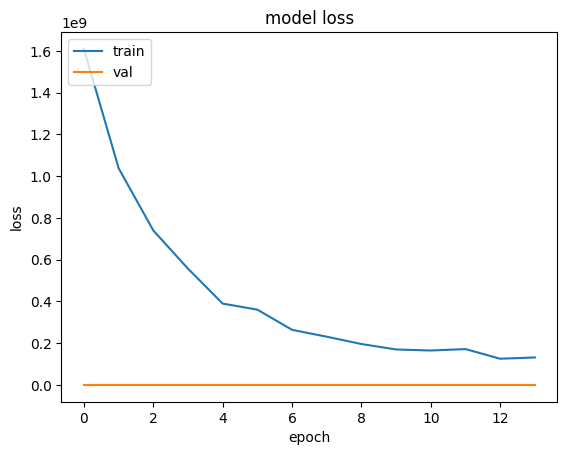

In [6]:
from sklearn.model_selection import train_test_split
zeros = np.zeros((len(cars),))

X_train, X_test, y_train, y_test = train_test_split(cars, zeros, test_size=0.05, random_state=42)

history = extract_model.fit(X_train, y_train, epochs=16, batch_size=16, validation_split=0.2)
plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

0


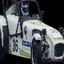

1


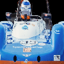

2


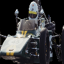

3


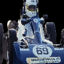

4


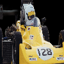

5


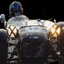

6


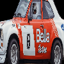

7


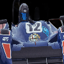

8


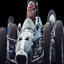

9


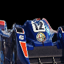

10


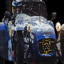

11


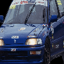

12


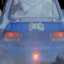

13


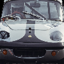

14


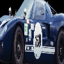

15


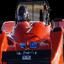

16


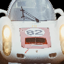

17


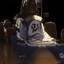

18


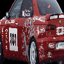

19


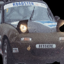

20


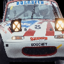

21


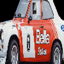

22


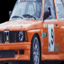

23


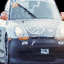

24


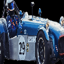

25


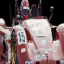

26


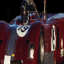

27


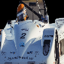

28


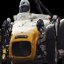

29


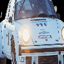

30


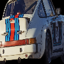

31


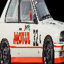

32


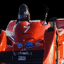

33


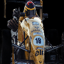

34


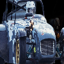

35


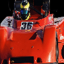

36


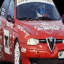

37


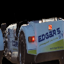

38


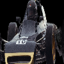

39


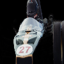

40


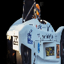

41


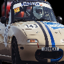

42


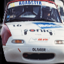

43


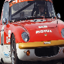

44


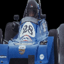

45


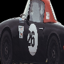

46


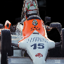

47


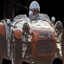

48


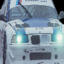

49


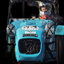

50


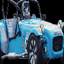

51


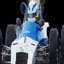

52


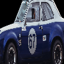

53


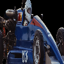

54


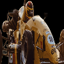

55


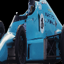

56


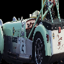

57


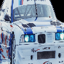

58


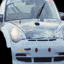

59


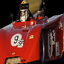

60


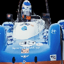

61


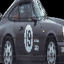

62


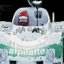

63


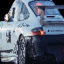

64


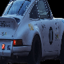

65


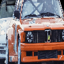

66


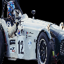

67


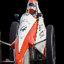

68


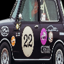

69


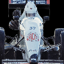

70


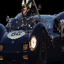

71


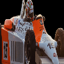

72


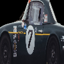

73


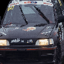

74


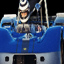

75


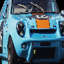

76


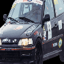

77


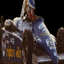

78


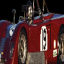

79


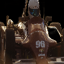

80


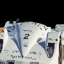

81


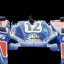

82


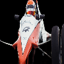

83


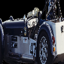

84


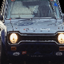

85


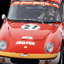

86


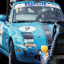

87


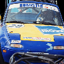

88


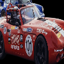

89


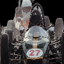

90


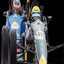

91


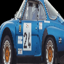

92


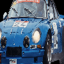

93


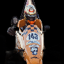

94


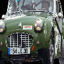

95


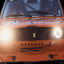

96


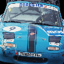

97


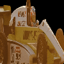

98


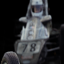

99


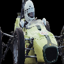

100


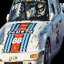

101


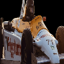

102


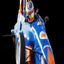

103


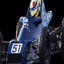

104


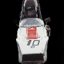

105


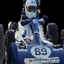

106


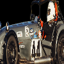

107


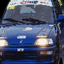

108


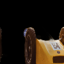

109


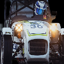

110


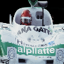

111


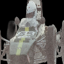

112


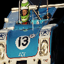

113


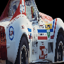

114


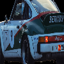

115


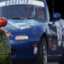

116


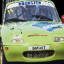

117


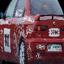

118


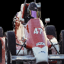

119


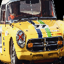

120


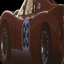

121


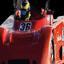

122


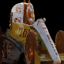

123


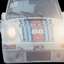

124


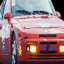

125


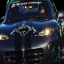

126


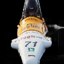

127


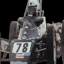

128


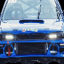

129


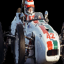

130


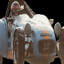

131


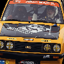

132


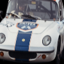

133


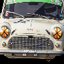

134


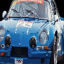

135


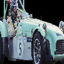

136


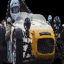

137


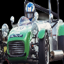

138


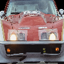

139


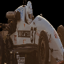

140


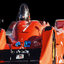

141


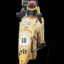

142


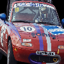

143


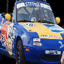

144


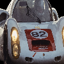

145


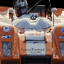

146


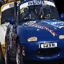

147


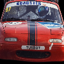

148


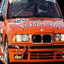

149


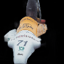

150


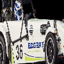

151


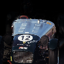

152


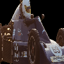

153


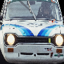

154


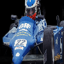

155


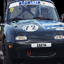

156


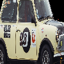

157


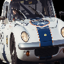

158


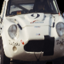

159


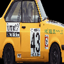

160


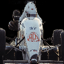

161


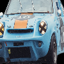

162


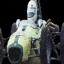

163


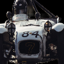

164


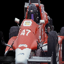

165


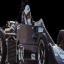

166


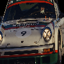

167


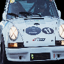

168


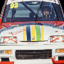

169


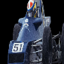

170


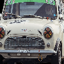

171


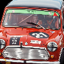

172


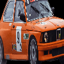

173


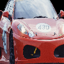

174


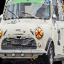

175


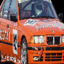

176


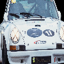

177


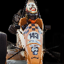

178


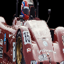

179


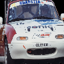

180


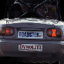

181


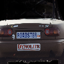

182


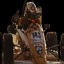

183


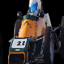

184


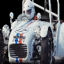

185


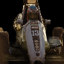

186


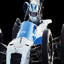

187


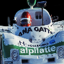

188


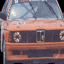

189


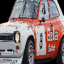

190


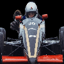

191


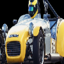

192


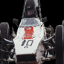

193


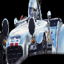

194


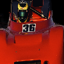

195


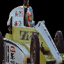

196


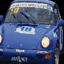

197


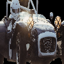

198


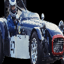

199


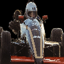

In [10]:
for i in range(200):
    print(0 + i)
    display_image(cars[0+i], size=64)
# 32 35
# 123 100
# 215 149

For a given car, show the closest cars to that one from the features extracted. 

tf.Tensor([     3.6326     -1.8832     -1.9805      6.4336      9.4346      10.482     -1.2908    -0.44566     -4.6821     0.35001], shape=(10,), dtype=float32)
tf.Tensor([    -4.4038      7.0468      13.658      8.1559     -7.1629     -1.3447     -30.292      2.2857     -7.9537      18.161], shape=(10,), dtype=float32)


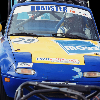

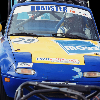

0.0


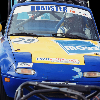

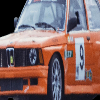

62.36160659790039


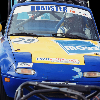

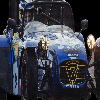

62.59096908569336


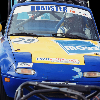

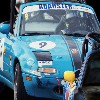

62.61347961425781


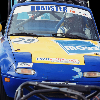

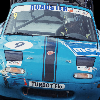

64.39682006835938


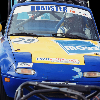

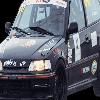

69.1751708984375


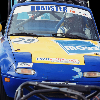

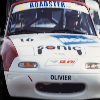

69.3941650390625


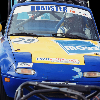

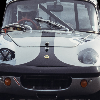

72.37274932861328


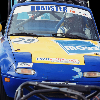

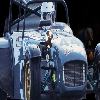

73.10346221923828


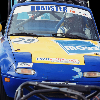

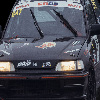

73.60685729980469


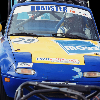

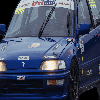

73.90349578857422


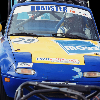

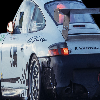

76.8341064453125


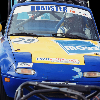

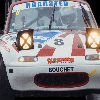

78.70642852783203


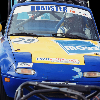

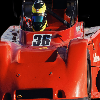

81.21041870117188


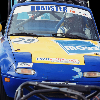

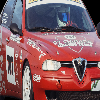

81.83647918701172


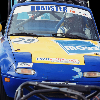

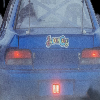

82.36190795898438


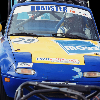

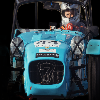

82.55914306640625


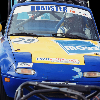

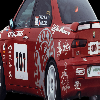

82.55963897705078


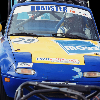

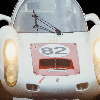

83.91993713378906


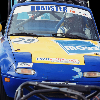

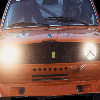

84.3563003540039


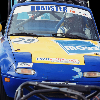

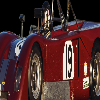

84.41130828857422


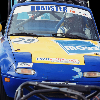

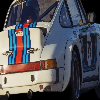

85.17411804199219


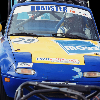

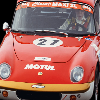

85.23233795166016


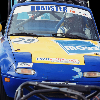

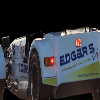

85.25547790527344


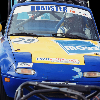

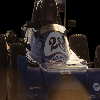

86.50080108642578


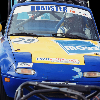

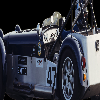

86.88490295410156


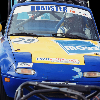

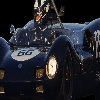

87.78398895263672


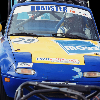

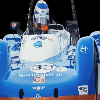

88.02606201171875


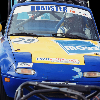

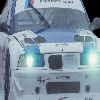

88.14781951904297


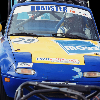

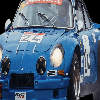

88.50814056396484


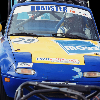

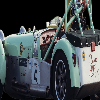

88.92034149169922


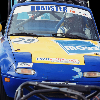

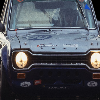

89.32952880859375


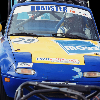

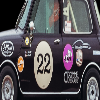

90.91592407226562


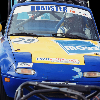

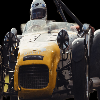

91.03201293945312


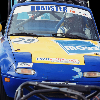

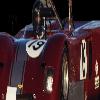

91.7607421875


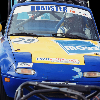

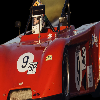

92.79376220703125


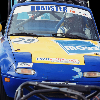

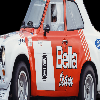

93.17161560058594


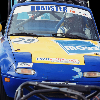

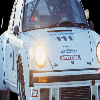

93.25808715820312


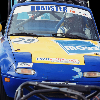

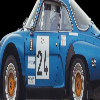

94.30636596679688


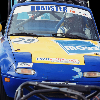

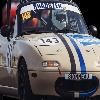

94.53948211669922


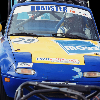

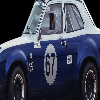

96.51786804199219


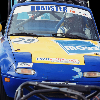

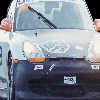

97.09518432617188


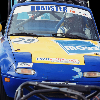

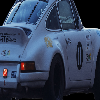

98.23246765136719


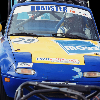

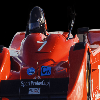

100.6720962524414


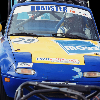

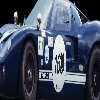

100.90186309814453


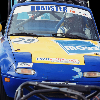

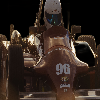

101.00841522216797


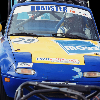

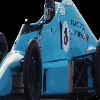

101.2758560180664


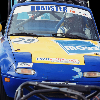

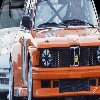

102.04824829101562


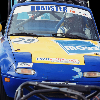

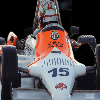

102.15679931640625


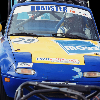

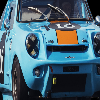

103.66099548339844


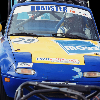

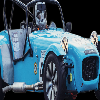

104.2220687866211


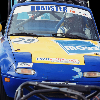

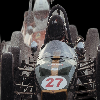

104.50505828857422


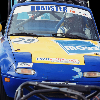

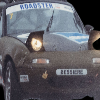

105.17447662353516


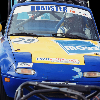

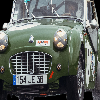

106.02352905273438


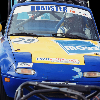

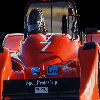

106.45059204101562


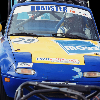

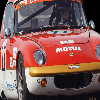

108.73766326904297


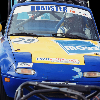

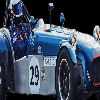

111.57038116455078


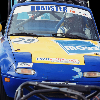

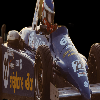

112.75078582763672


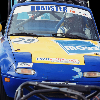

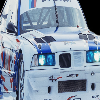

115.67667388916016


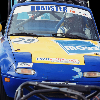

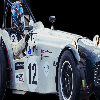

116.45172882080078


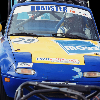

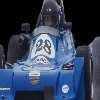

118.87310791015625


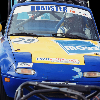

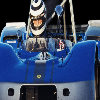

120.5737075805664


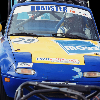

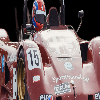

122.20066833496094


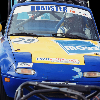

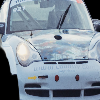

123.177490234375


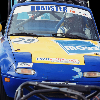

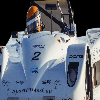

124.25079345703125


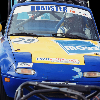

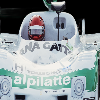

124.57150268554688


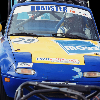

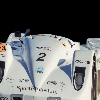

125.47592163085938


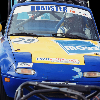

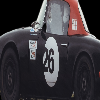

125.75952911376953


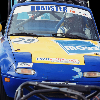

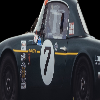

130.33444213867188


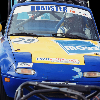

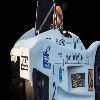

133.6020050048828


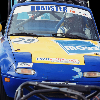

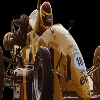

134.65159606933594


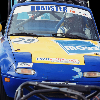

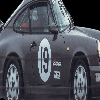

135.68682861328125


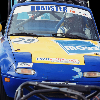

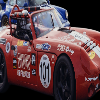

136.4834747314453


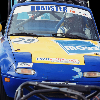

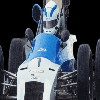

137.22962951660156


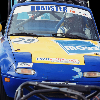

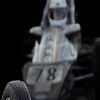

138.3218994140625


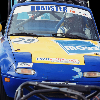

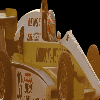

139.9112091064453


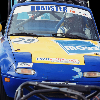

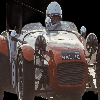

143.7374267578125


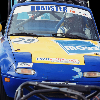

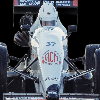

153.0760955810547


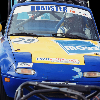

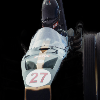

163.70196533203125


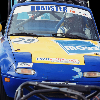

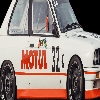

163.84115600585938


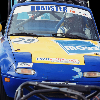

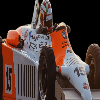

165.66197204589844


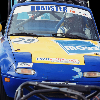

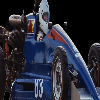

167.1226043701172


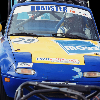

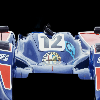

181.44570922851562


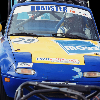

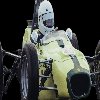

183.93557739257812


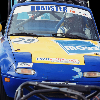

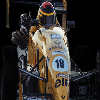

188.19216918945312


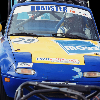

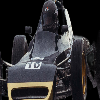

201.3175811767578


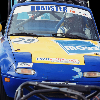

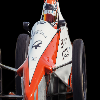

216.30282592773438


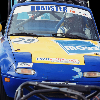

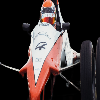

227.28964233398438


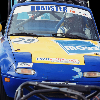

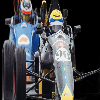

243.18865966796875


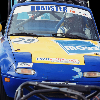

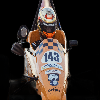

279.29962158203125


In [12]:
car1 = cars[87]
input_car = extract_model.layers[0](np.expand_dims(car1, axis=0))
embedding1 = extract_model.layers[2](input_car)
print(embedding1[0][:10])

out = []
for i in range(10, 100, 1):
    input_car = extract_model.layers[0](np.expand_dims(cars[i], axis=0))
    embedding2 = extract_model.layers[2](input_car)
    d = tf.sqrt(tf.reduce_sum(tf.square(embedding1 - embedding2), axis=1)).numpy()[0]
    out.append({'car_id': i, 'distance': d})

print(embedding2[0][:10])

df = pl.from_dicts(out)
for car in df.sort("distance").rows(named=True):
    display_image(car1, size=100)
    display_image(cars[car['car_id']], size=100)
    print(car['distance'])

In [13]:
extract_model.save("extraction_model_all")

INFO:tensorflow:Assets written to: extraction_model_all/assets


INFO:tensorflow:Assets written to: extraction_model_all/assets


In [272]:
extract_model = tf.keras.models.load_model("extraction_model/")